In [2]:
# Formatação
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# Setup
from math import floor
import numpy as np
import cv2
import skimage
import scipy
from matplotlib import pyplot
from helper import full_identification_process, full_age_counting_process, load_img, mahalanobis_distance_from_mean, normalize_0_to_1
from count_changes.count_changes import count_changes as c_count_changes

In [110]:
img_path = 'image/sequence 1/6.jpeg'
original = load_img(img_path)

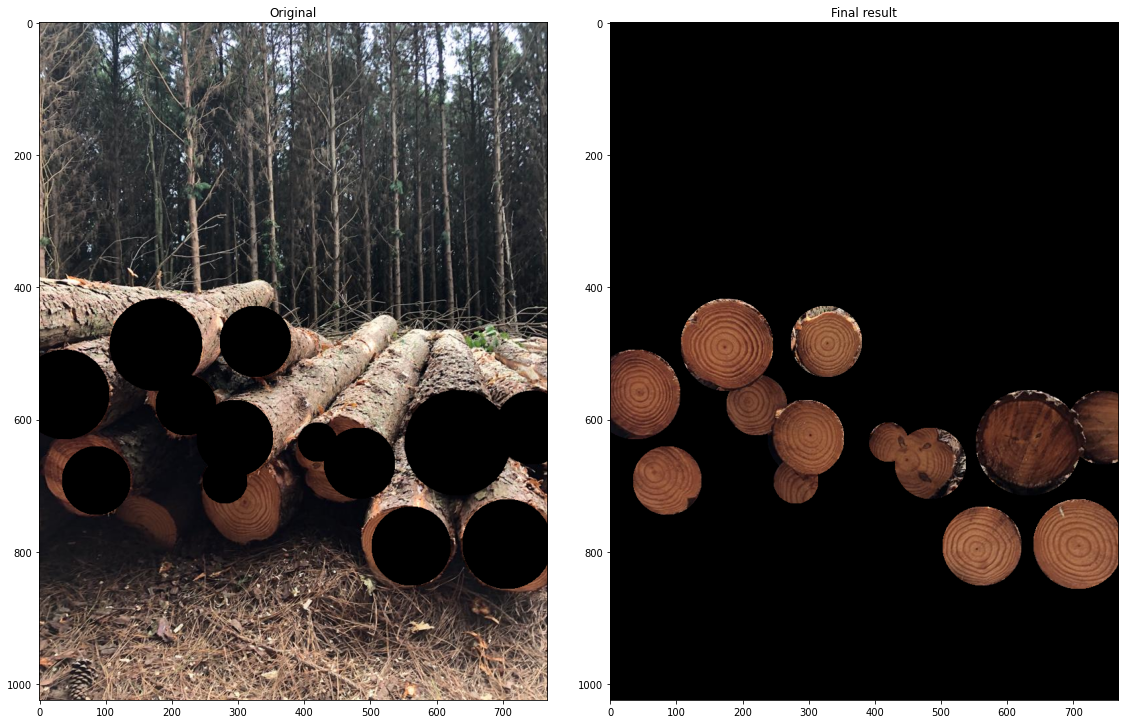

In [111]:
disk_canvas, disks = full_identification_process(original)

disks_on_img = np.copy(original)
disks_on_img[disk_canvas == 0] = (0, 0, 0)
disks_removed = np.copy(original)
disks_removed[disk_canvas == 1] = (0, 0, 0)

fig, ax = pyplot.subplots(ncols=2, nrows=1, figsize=(16, 10))
fig.tight_layout()

ax[0].imshow(disks_removed)
ax[0].set_title("Original")
ax[1].imshow(disks_on_img)
ax[1].set_title("Final result")

pyplot.show()

Seleciona uma das toras encontradas e a recorta da imagem.

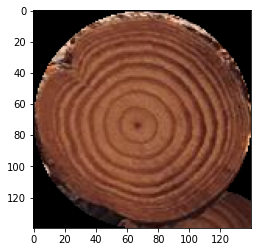

In [214]:
disk = disks[1]

y_lim = [disk[1]-disk[2], disk[1]+disk[2]]
if y_lim[0] < 0:
	y_lim[0] = 0
if y_lim[1] >= disks_on_img.shape[0]:
	y_lim[1] = disks_on_img.shape[0] - 1

x_lim = [disk[0]-disk[2], disk[0]+disk[2]]
if x_lim[0] < 0:
	x_lim[0] = 0
if x_lim[1] >= disks_on_img.shape[0]:
	x_lim[1] = disks_on_img.shape[0] - 1


disk_img = disks_on_img[y_lim[0]:y_lim[1], x_lim[0]:x_lim[1]]

pyplot.imshow(disk_img)
pyplot.show()

Usa distancia de mahalanobis para tentar eliminar o casco do tora na borda do recorte. Ao contrario do processo de identificação, HSV não apresentou bons resultados aqui, convertendo para CieLAB funcionou um pouco melhor mas ainda não ficou o ideal. Uma possibilidade de melhoria seria usar Mahalnobis polinomial porém tal possibilidade nao chegou a ser testada.

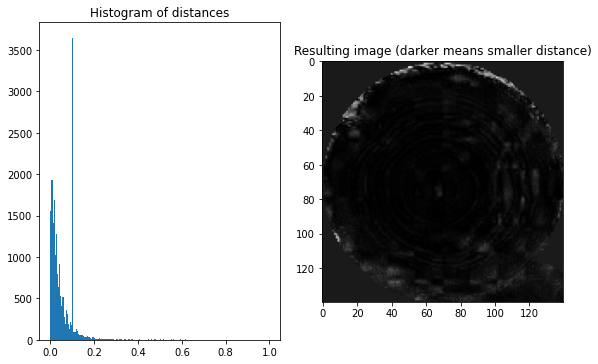

In [202]:
y_lim = disk_img.shape[0]
x_lim = disk_img.shape[1]
disk_img_LAB = np.copy(disk_img)
disk_img_LAB = cv2.cvtColor(disk_img_LAB, cv2.COLOR_RGB2LAB)
pixels = np.copy(disk_img_LAB[y_lim // 4 : y_lim - y_lim // 4, x_lim // 4 : x_lim - x_lim // 4].reshape((-1, 3)))
disk_img_LAB = disk_img_LAB.reshape((-1, 3))

covar_matrix = np.cov(disk_img_LAB.T)
distances = mahalanobis_distance_from_mean(disk_img_LAB, np.mean(pixels, 0), covar_matrix)
distances = normalize_0_to_1(distances)
distances_img = distances.reshape(disk_img.shape[0], disk_img.shape[1])

fig, ax = pyplot.subplots(ncols=2, nrows=1, figsize=(8, 5))
fig.tight_layout()

ax[0].hist(distances, 200)
ax[0].set_title("Histogram of distances")
ax[1].imshow(distances_img, cmap='gray')
ax[1].set_title("Resulting image (darker means smaller distance)")

pyplot.show()

Aplica-se threshold baseado em Mahalnobis seguido de abertura e fechamento para evitar possiveis buracos na mascara localizados no interior da região de interesse.

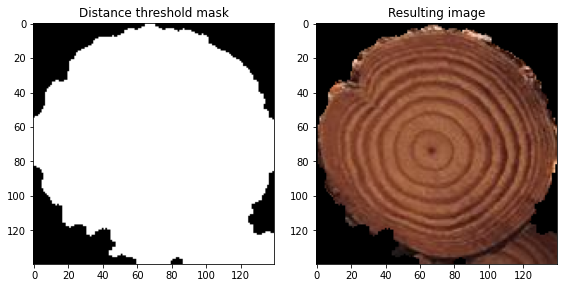

In [203]:
threshhold_mask = np.zeros(distances_img.shape)
threshhold_mask[distances_img < 0.1] = 1

kernel_size = 5
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
threshhold_mask = cv2.morphologyEx(threshhold_mask, cv2.MORPH_CLOSE, kernel)
kernel_size = 5
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
threshhold_mask = cv2.morphologyEx(threshhold_mask, cv2.MORPH_OPEN, kernel)

threshhold_img = np.copy(disk_img)
threshhold_img[threshhold_mask != 1] = [0, 0, 0]

fig, ax = pyplot.subplots(ncols=2, nrows=1, figsize=(8, 5))
fig.tight_layout()

ax[0].imshow(threshhold_mask, cmap='gray')
ax[0].set_title("Distance threshold mask")
ax[1].imshow(threshhold_img)
ax[1].set_title("Resulting image")

pyplot.show()

Imagem é aumentada pois com tamanho pequeno a conversão polar do opencv eliminava muita informação. É feita equalização de histograma e as regiões separadas numa classificação binária de regiões escuras e claras baseado em um limiar.

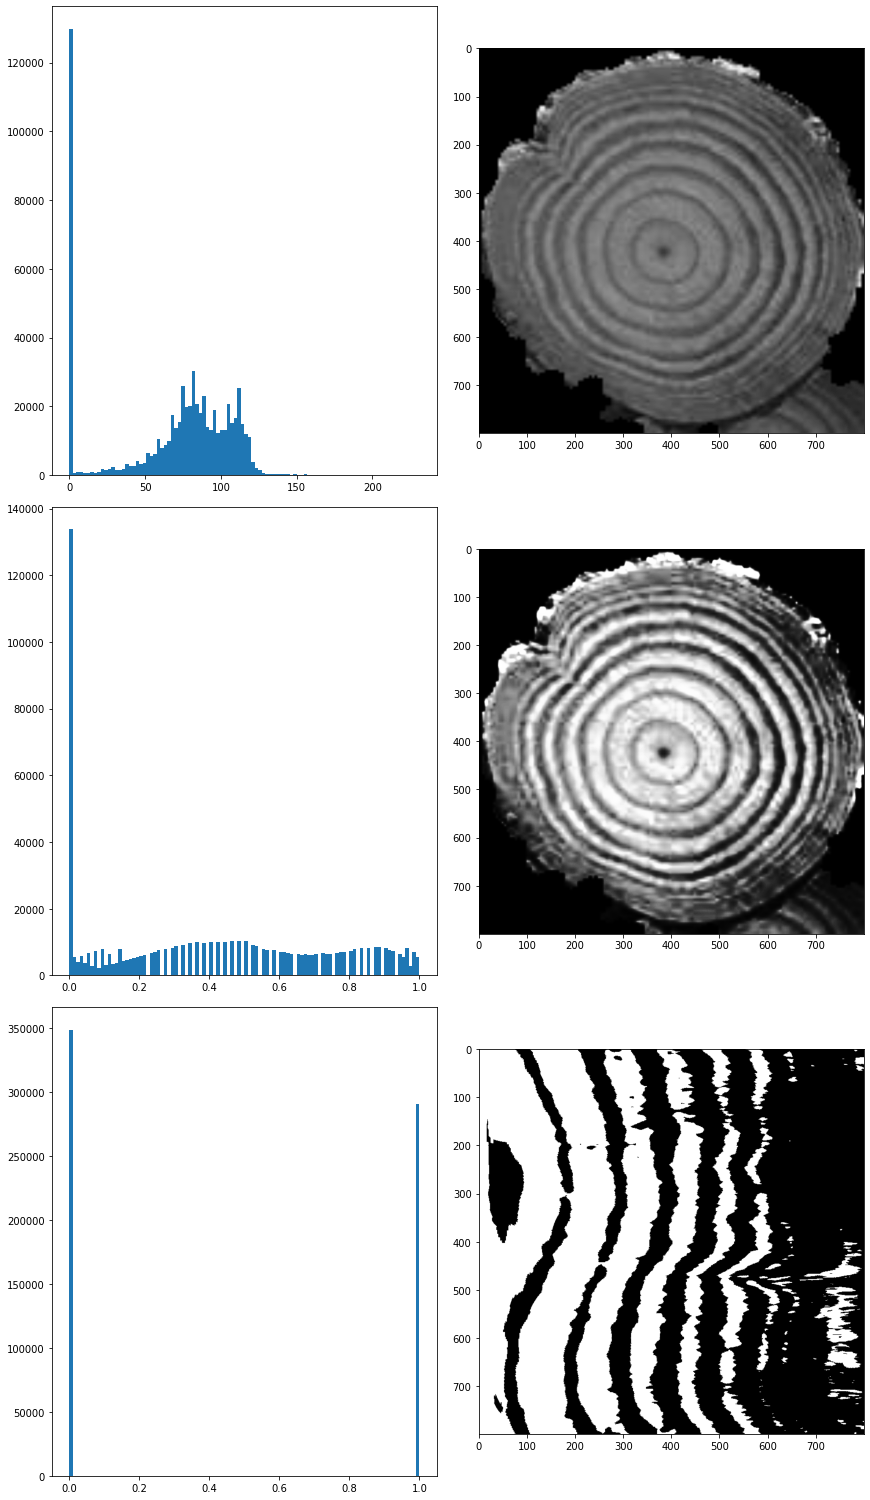

In [211]:
size = 800
resized = cv2.resize(threshhold_img, (size, size))
gray_img = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY)

equalized = cv2.equalizeHist(gray_img)

equalized = normalize_0_to_1(equalized)

threshold = 0.7
equalized_threshold = np.copy(equalized)
equalized_threshold[equalized < threshold] = 0
equalized_threshold[threshold < equalized] = 1

polar = cv2.linearPolar(equalized_threshold, (size/2, size/2), size/2, cv2.WARP_FILL_OUTLIERS)


fig, ax = pyplot.subplots(ncols=2, nrows=3, figsize=(12, 21))
fig.tight_layout()

ax[0, 0].hist(gray_img.flatten(), 100)
ax[0, 1].imshow(gray_img, cmap='gray')
ax[1, 0].hist(equalized.flatten(), 100)
ax[1, 1].imshow(equalized, cmap='gray')
ax[2, 0].hist(polar.flatten(), 100)
ax[2, 1].imshow(polar, cmap='gray')
pyplot.show()

Percorre-se a representação em 50 linhas equidistantes, contando a quantidade de vezes que o valor muda. O valor é dividido por dois para se obter então os anéis e um valor médio dentre os obtidos com as 50 linhas é adotado como estimativa final. Dentre média, mediana e moda, a mediana pareceu dar melhor acurácia ao método baseando-se nos testes feitos.

std_dev: 1.8932511719262186 - mean: 18.34 - median: 18.0 - mode: 18.0
guesses: 8 - 8 - 8


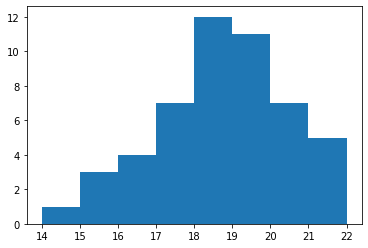

In [205]:
n = 50
changes = c_count_changes(polar.astype(np.int32), n)
std_dev = np.std(changes)
mean = np.mean(changes)
median = np.median(changes)
mode = np.mean(scipy.stats.mode(changes)[0]) # em caso de mais de uma moda, toma media das modas
print(f'std_dev: {std_dev} - mean: {mean} - median: {median} - mode: {mode}')
# subtrai 1 para não contabilizar a mudança de cor ao passar para fora da tora
print(f'guesses: {floor((mean - 1) / 2)} - {floor((median - 1) / 2)} - {floor((mode - 1) / 2)}')
pyplot.hist(changes, bins=np.arange(changes.min(), changes.max() + 1, 1))
pyplot.show()